# Mapping water extent and rainfall

* **Products used:** 
[wofs_ls](https://explorer.digitalearth.africa/products/wofs_ls),
[rainfall_chirps_monthly](https://explorer.digitalearth.africa/products/rainfall_chirps_monthly)

## Background


## Description

***

## Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt

from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.datahandling import wofs_fuser

from long_term_water_extent import (
    load_vector_file,
    get_resampled_labels,
    resample_water_observations,
    resample_rainfall_observations,
    calculate_change_in_extent,
    compare_extent_and_rainfall,
)

## Set up a Dask cluster

Dask can be used to better manage memory use and conduct the analysis in parallel. 

In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:46267 Dashboard: /user/chad/proxy/8787/status,Cluster Workers: 1 Cores: 4 Memory: 28.14 GB


## Connect to Data Cube

In [3]:
dc = datacube.Datacube(app="long_term_water_extent")

## Analysis parameters

The following cell sets the parameters, which define the area of interest and the length of time to conduct the analysis over.

* Upload a vector file for your water extent and your catchment to the `data` folder.
* Set the time range you want to use.
* Set the resampling strategy. Possible options include:
    *  `"1Y"` - Annual resampling, use this option for longer term monitoring
    * `"QS-DEC"` - Quarterly resampling from December
    * `"3M"` - Three-monthly resampling
    * `"1M"` - Monthly resampling

For more details on resampling timeframes, see the [xarray](https://xarray.pydata.org/en/v0.8.2/generated/xarray.Dataset.resample.html#r29) and [pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects) documentation.

In [4]:
water_extent_vector_file = "data/lake_baringo_extent.geojson"

water_catchment_vector_file = "data/lake_baringo_catchment.geojson"

time_range = ("2018-07", "2021")

resample_strategy = "Q-DEC"

dask_chunks = dict(x=1000, y=1000)

## Get waterbody and catchment geometries

The next cell will extract the waterbody and catchment geometries from the supplied vector files, which will be used to load Water Observations from Space and the CHIRPS rainfall products.

In [5]:
extent, extent_geometry = load_vector_file(water_extent_vector_file)
catchment, catchment_geometry = load_vector_file(water_catchment_vector_file)

## Load Water Observation from Space for Waterbody

The first step is to load the Water Observations from Space product using the extent geometry.

In [6]:
extent_query = {
    "time": time_range,
    "resolution": (-30, 30),
    "output_crs": "EPSG:6933",
    "geopolygon": extent_geometry,
    "group_by": "solar_day",
    "dask_chunks":dask_chunks
}

wofs_ds = dc.load(product="wofs_ls", fuse_func=wofs_fuser, **extent_query)

### Identify water in each resampling period

The second step is to resample the observations to get a consistent measure of the waterbody, and then calculate the classified as water for each period.

In [7]:
resampled_water_ds, resampled_water_area_ds = resample_water_observations(
    wofs_ds, resample_strategy
)
date_range_labels = get_resampled_labels(wofs_ds, resample_strategy)

### Plot the change in water area over time

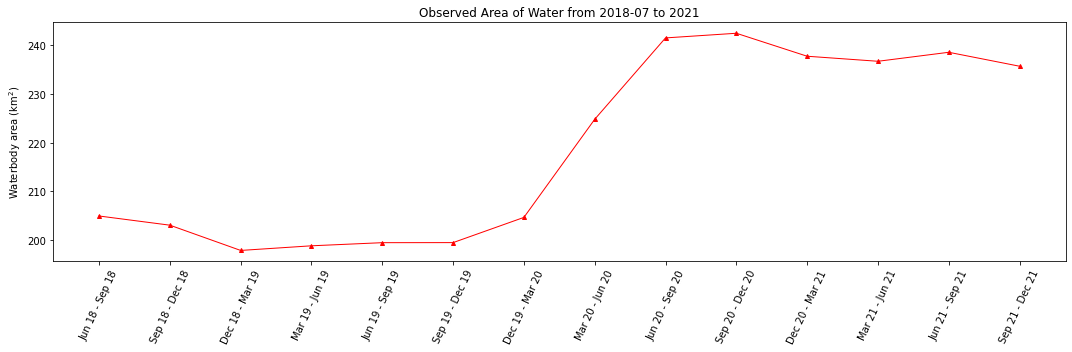

In [8]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(
    date_range_labels,
    resampled_water_area_ds.values,
    color="red",
    marker="^",
    markersize=4,
    linewidth=1,
)
plt.xticks(date_range_labels, rotation=65)
plt.title(f"Observed Area of Water from {time_range[0]} to {time_range[1]}")
plt.ylabel("Waterbody area (km$^2$)")
plt.tight_layout()

## Load CHIRPS monthly rainfall



In [9]:
catchment_query = {
    "time": time_range,
    "resolution": (-5000, 5000),
    "output_crs": "EPSG:6933",
    "geopolygon": catchment_geometry,
    "group_by": "solar_day",
    "dask_chunks":dask_chunks
}

rainfall_ds = dc.load(product="rainfall_chirps_monthly", **catchment_query)

### Resample to estimate rainfall for each time period

This is done by taking calculating the average rainfall over the extent of the catchment, then summing these averages over the resampling period to estimate the total rainfall for the catchment.

In [10]:
catchment_rainfall_resampled_ds = resample_rainfall_observations(
    rainfall_ds, resample_strategy, catchment
)

## Compare waterbody area to catchment rainfall

This step plots the summed average rainfall for the catchment area over each period as a histogram, overlaid with the waterbody area calculated previously.

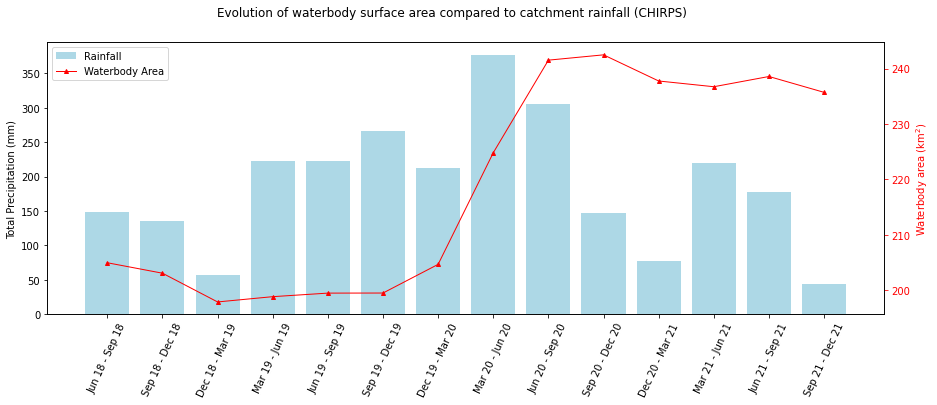

In [11]:
figure = compare_extent_and_rainfall(
    resampled_water_area_ds, catchment_rainfall_resampled_ds, "mm", date_range_labels
)

### Save the figure

In [12]:
figure.savefig("waterarea_and_rainfall.png", bbox_inches="tight")

## Compare water extent for two different periods

For the next step, enter a baseline date, and an analysis date to construct a plot showing where water appeared, as well as disappeared, by comparing the two dates.

In [13]:
baseline_time = "2002-01-01"
analysis_time = "2020-01-01"

x_pix 568
y_pix 1212


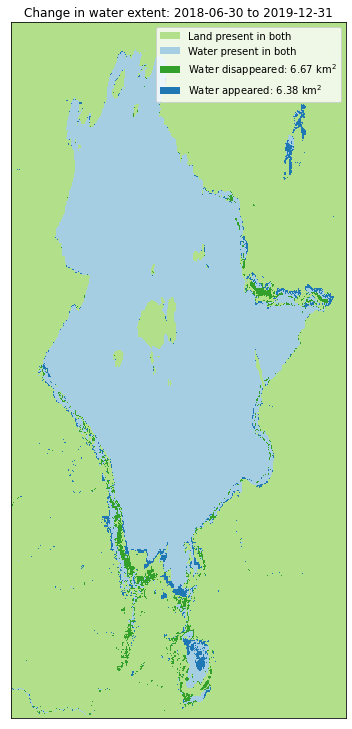

In [14]:
figure = calculate_change_in_extent(baseline_time, analysis_time, resampled_water_ds)

### Save figure

In [15]:
figure.savefig("waterarea_change.png", bbox_inches="tight")

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [16]:
print(datacube.__version__)

1.8.6


**Last Tested:**

In [17]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2021-12-22'